### Initializations & Parameters

#### Imports

In [186]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd
hexad_types_full = ["Player", "Achiever", "Philanthropist", "Disruptor", "Socializer", "Free Spirit"]

#### Environment Init

In [187]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e[1::2]
colors=['violet','purple','red','sienna',
        'darkorange','burlywood','gold','darkgoldenrod',
        'olivedrab','lawngreen','deepskyblue','steelblue']
ge2c={"Nothing":'black'}
for i in range(len(g_e)):
    ge2c[g_e[i].name]=colors[i]
#hexad=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict
hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty=0.05
fatigue_replenishment=0.01
nothing_reward=75
ranges=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)
pref_min=0.2
seed=10101

In [188]:
(fatigue_replenishment/fatigue_penalty)

0.19999999999999998

In [189]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=ranges,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [190]:
uncertainty=.1
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1
#ht=copy.deepcopy(hexad)
ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [191]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [192]:
#general parameters
learn_rate=0.002
discount_factor=0.7

In [193]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.025
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [194]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

  2%|▏         | 15/1000 [00:00<00:25, 38.18it/s]

100%|██████████| 1000/1000 [00:21<00:00, 47.57it/s]


In [195]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.025
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [196]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )

train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

100%|██████████| 1000/1000 [00:18<00:00, 55.52it/s]


In [197]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


100%|██████████| 1000000/1000000 [00:19<00:00, 51421.98it/s]


In [198]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [199]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


100%|██████████| 1000/1000 [00:16<00:00, 60.01it/s]


In [200]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}

#### Testing Functions

In [201]:
def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    hexad_diff=[]
    hd_stats={'mean':[],'std':[]}
    obs,info=env.reset()
    for i in tqdm(range(test_iterations),leave=False):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        diff=0
        d_s=[]
        for typ,val in answer_bot.hexad_profile.items():
            v=abs(val-env.hexad_adjusted[typ])
            diff+=v
            d_s.append(v)
        hd_stats['mean'].append(np.mean(d_s))
        hd_stats['std'].append(np.std(d_s))
        hexad_diff.append(diff)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info),hexad_diff,hd_stats

In [202]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(15,10))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            type_index=7
        plt.subplot(7,1,type_index)
        plt.ylim(0,800)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2,color=ge2c[name])
        ax=plt.gca()
        ax.legend()
    plt.figure(f+1)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5,color=ge2c[env.action_to_ge[i]])
        ax=plt.gca()
        ax.legend()

In [203]:
def plot_actionsX(actions,env,title=None,f=1,X=200):
    typ='pl'
    fig=plt.figure(f,figsize=(12,6))
    fig.suptitle("Σειρά ενεργειών και ανταμοιβές ανά τύπο Hexad στοιχείου\nΔράστης: {}".format(title))
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            type_index=8
        Eks=np.array(actions[i]['x'])
        Psi=np.array(actions[i]['y'])
        Psi=Psi[Eks<=X]
        Eks=Eks[Eks<=X]
        plt.subplot(3,3,type_index)
        fig.tight_layout(pad=1.0)
        plt.xlim(0,X)
        plt.ylim(0,800)
        if type_index in [1,4,8]:
            plt.ylabel("Ανταμοιβή")
        if type_index in [4,6,8]:
            plt.xlabel("Σειρά ενέργειας")
        ax=plt.gca()
        if hex_type!=None:
            ax.set_title(hexad_types_full[type_index-1])
        else:
            ax.set_title('Nothing')
        if Eks.size==0 or Psi.size==0: continue
        plt.scatter(Eks,Psi,label=name,s=2,color=ge2c[name])
        ax.legend()
    fig=plt.figure(f+1,figsize=(12,7))
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5,color=ge2c[env.action_to_ge[i]])
        plt.xlim(0,500)
        plt.ylabel("Ανταμοιβή")
        fig.suptitle("Σειρά ενεργειών και ανταμοιβές\nΔράστης: {}".format(title))
        plt.xlabel("Σειρά ενέργειας")
        ax=plt.gca()
        ax.legend()

In [204]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

### Testing

In [205]:
tests=500
retrains=1000
retrain_learn_rate=0.3

In [206]:
rewards={}
choices={}
best_choices={}
agent_error={}
actions={}
profile_diff={}
prof_stats={}
for name,agent in agents.items():
    bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )
    print(name)
    random_retrain=(name in ["Basic","BestOfX"])
    r,c,b,e,a,_,hd,hds=test_env_agent(env,agent,
                   answer_bot=bot,
                   test_iterations=tests,
                   retrain_iterations=retrains,
                   random_retrain=random_retrain,
                   training_lr=retrain_learn_rate)
    rewards[name]=r
    choices[name]=c
    best_choices[name]=b
    agent_error[name]=e
    actions[name]=a
    profile_diff[name]=hd
    prof_stats[name]=hds
    

Basic


Epsilon


BestOfX


FatigueAware


### Graphs

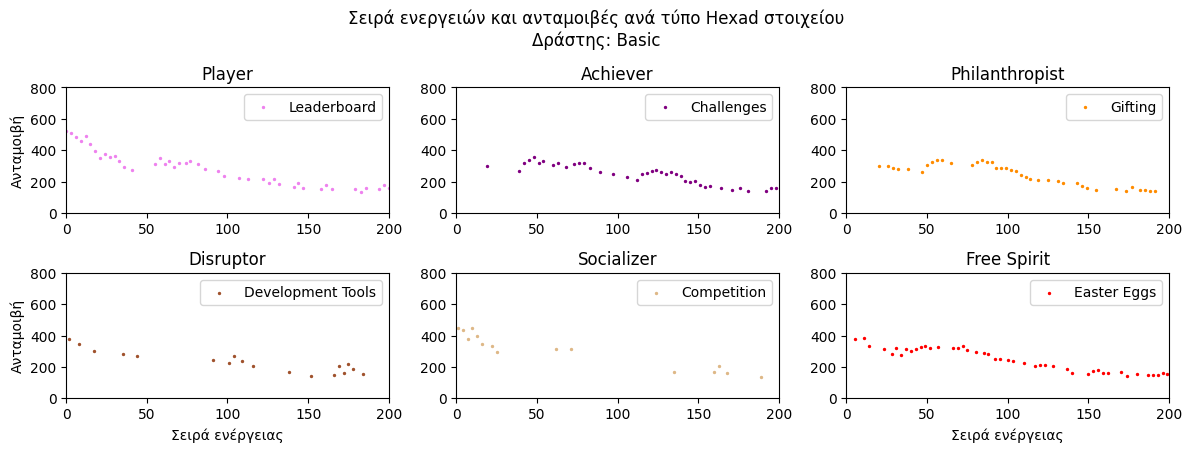

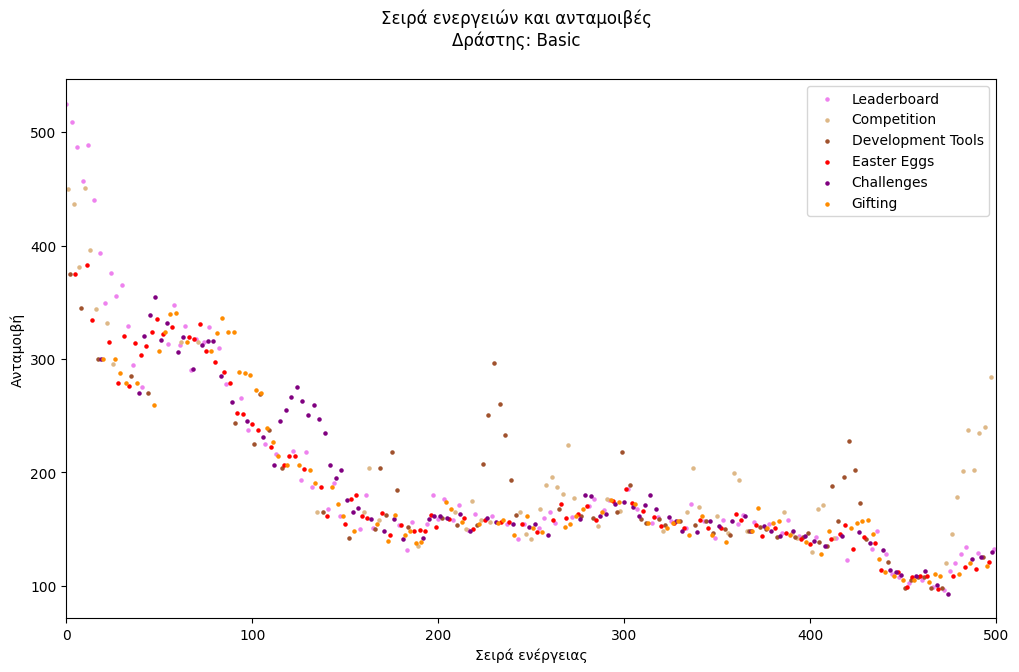

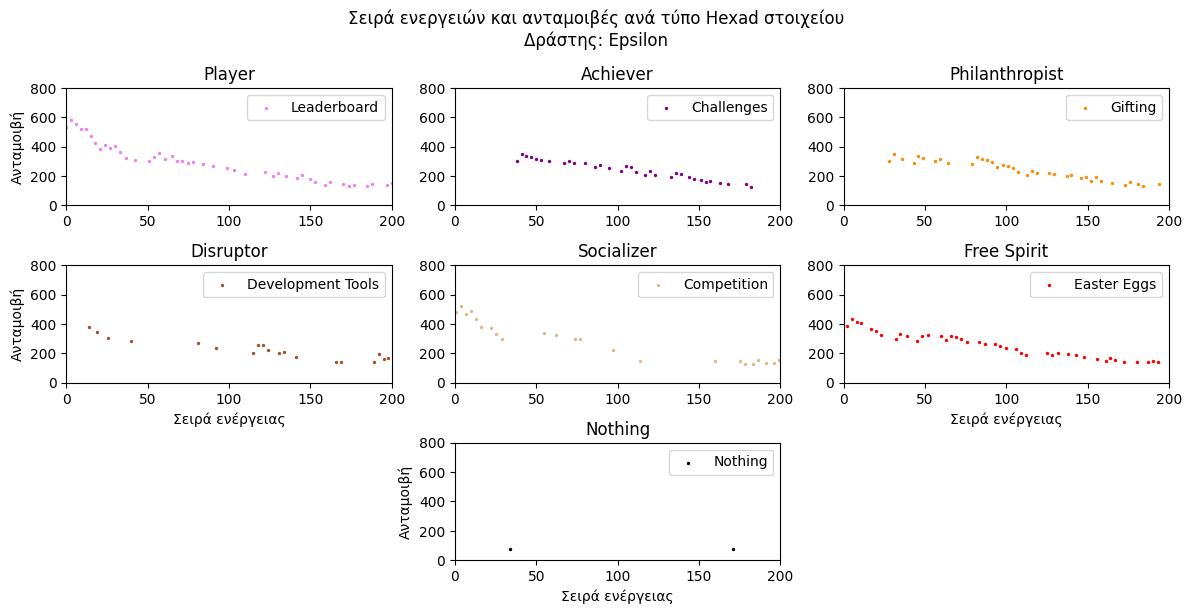

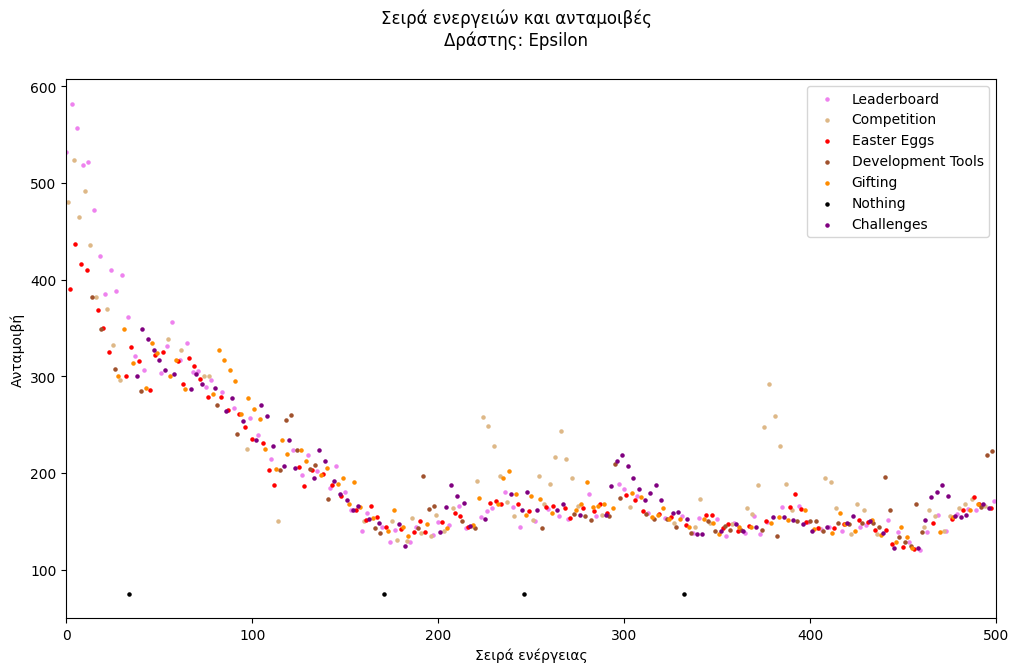

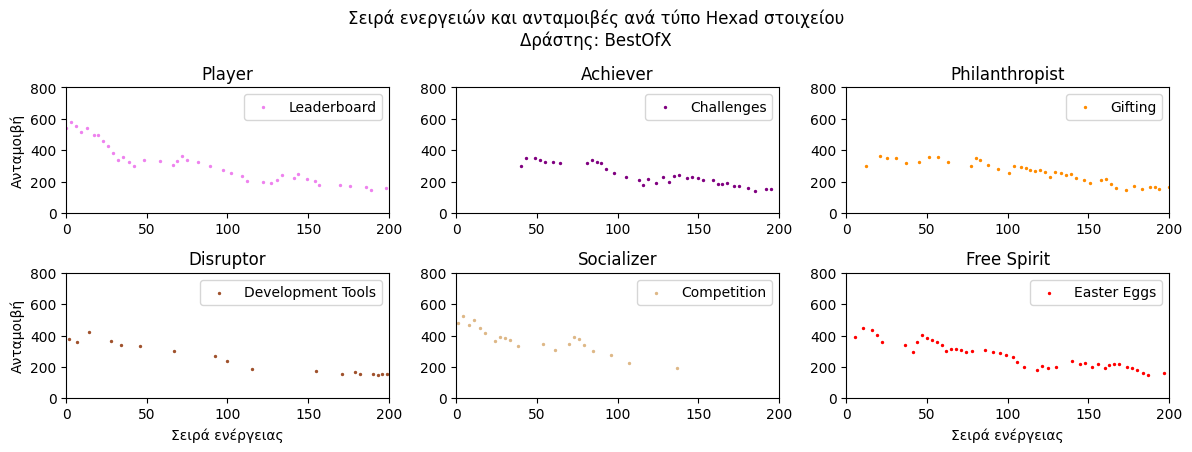

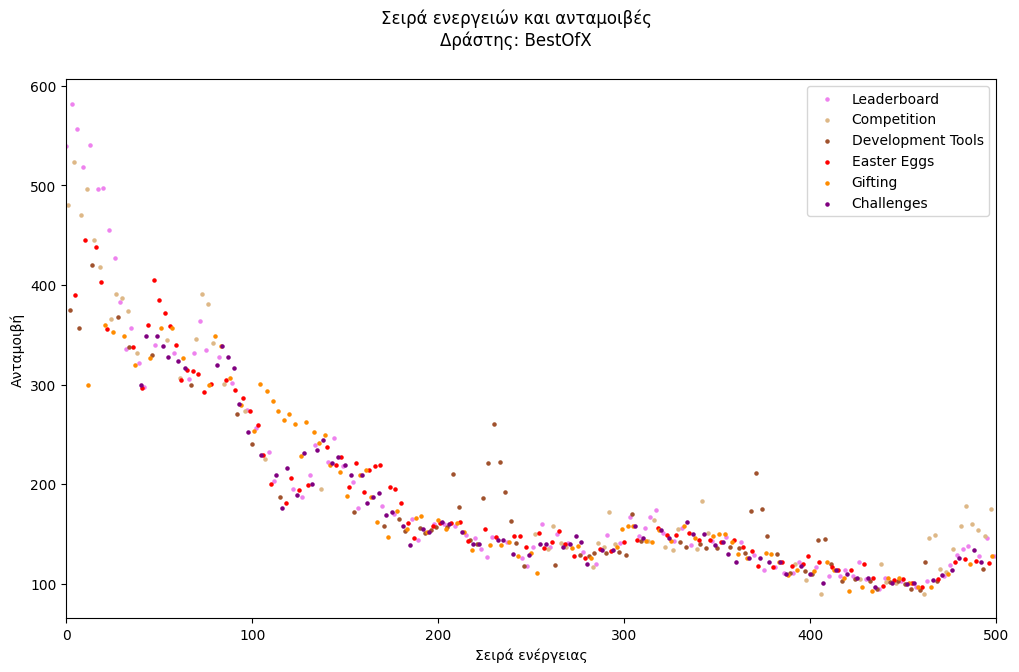

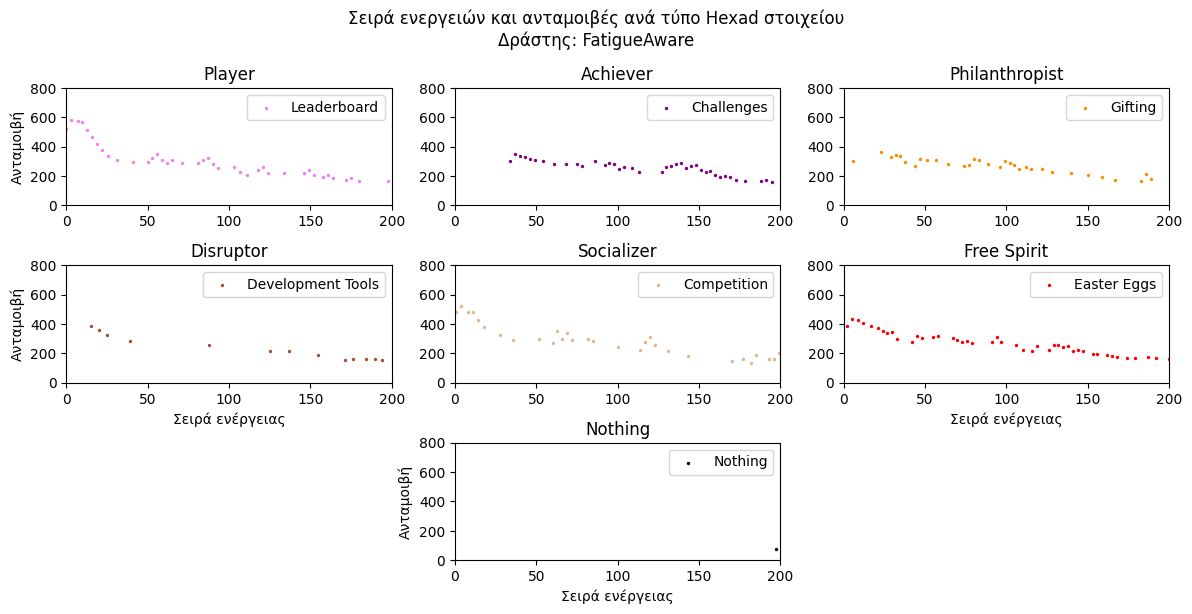

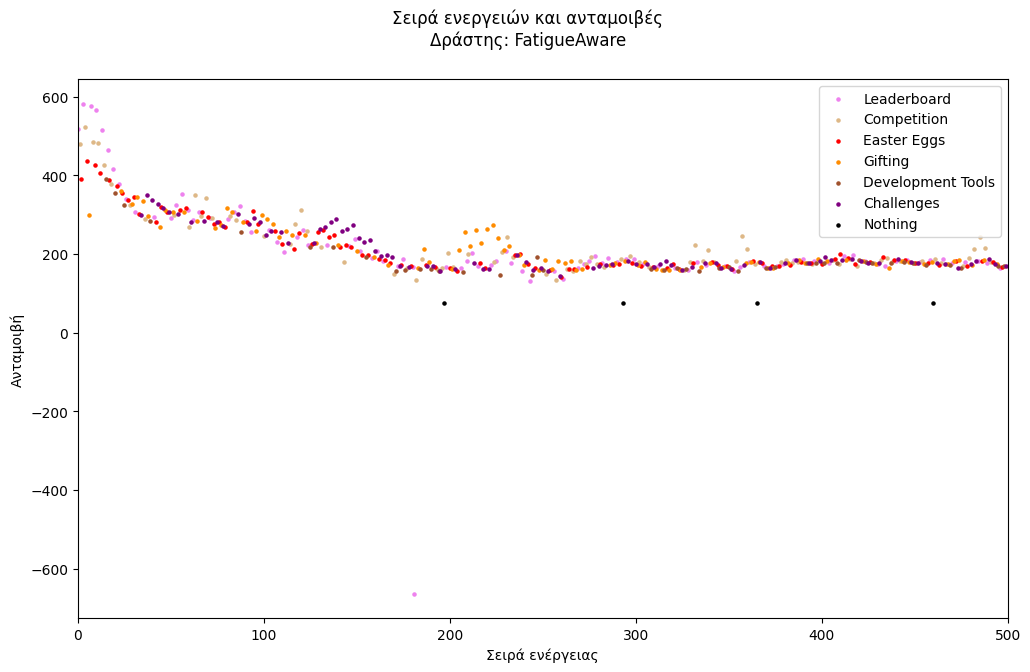

In [207]:
f=1
for name,acts in actions.items():
    plot_actionsX(actions=acts,env=env,title=name.format(name),f=f,X=200)
    f+=3

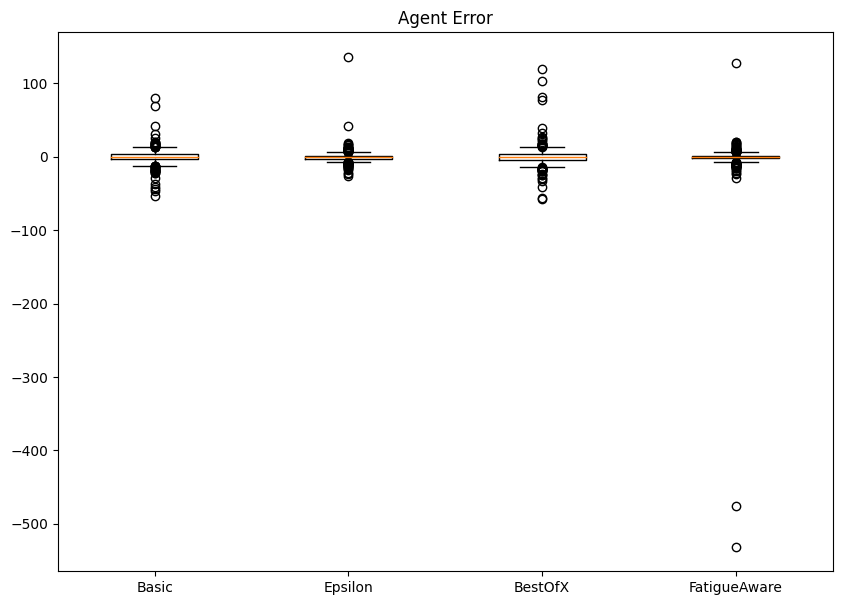

In [208]:
fig=plt.figure()
plt.title("Agent Error")
bp=plt.boxplot(agent_error.values(),labels=agent_error.keys())

In [209]:
type_stats={}
accuracies={}
diff_from_best={}
confusion_matrices={}
for agent in agents:
    t,acc,diff,conf_matrix = get_stats(actions[agent],best_choices[agent],[*zip(choices[agent],rewards[agent])])
    type_stats[agent]=t
    accuracies[agent]=acc
    diff_from_best[agent]=diff
    confusion_matrices[agent]=conf_matrix

Text(0.5, 1.0, 'Ακρίβεια Δραστών')

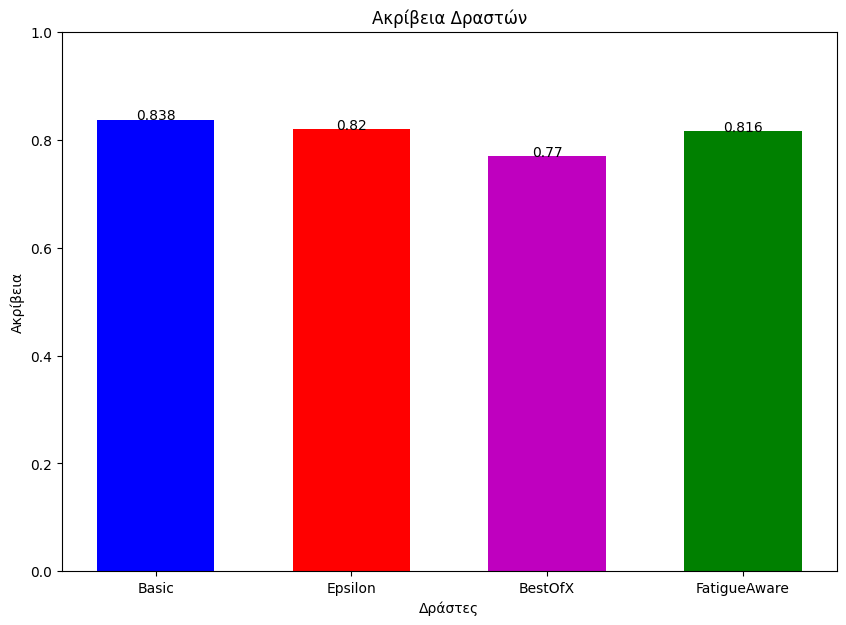

In [210]:
plt.bar(accuracies.keys(),accuracies.values(),color=['b','r','m','g'],width=0.6)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
addlabels([*accuracies.keys()],[*accuracies.values()])
plt.xlabel('Δράστες')
plt.ylabel('Ακρίβεια')
plt.ylim(0,1.0)
plt.title("Ακρίβεια Δραστών")

Text(0.5, 0, 'Δράστες')

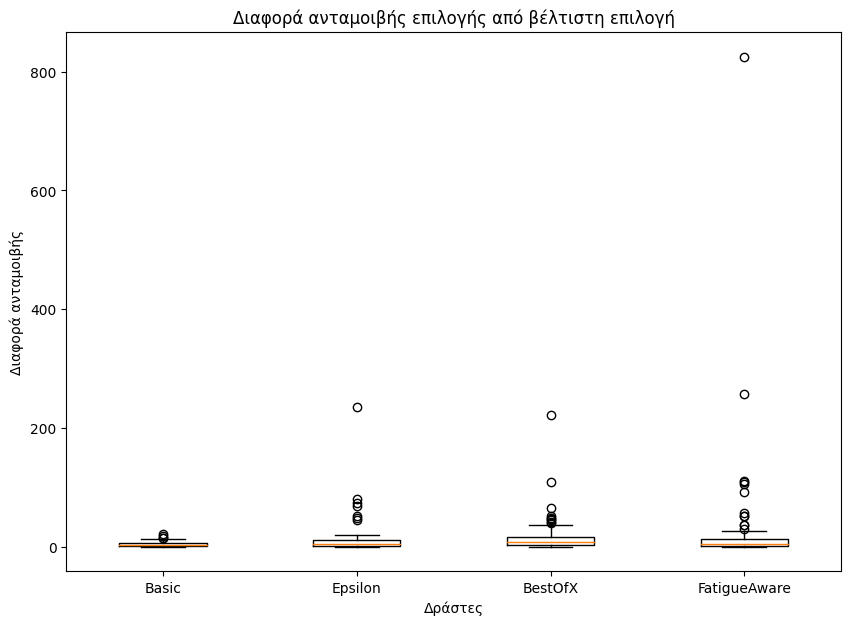

In [211]:
vs=diff_from_best.values()
vs2=[]
for i in vs:
    v=np.array(i)
    v=v[v>0.1]
    vs2.append(v)
bp=plt.boxplot(vs2,labels=diff_from_best.keys())
plt.title("Διαφορά ανταμοιβής επιλογής από βέλτιστη επιλογή")
plt.ylabel("Διαφορά ανταμοιβής")
plt.xlabel("Δράστες")

In [212]:
len([*range(1,len(prof_stats[name]['mean']),10)]), len(prof_stats[name]["mean"][::10])

(50, 50)

<Figure size 1000x700 with 0 Axes>

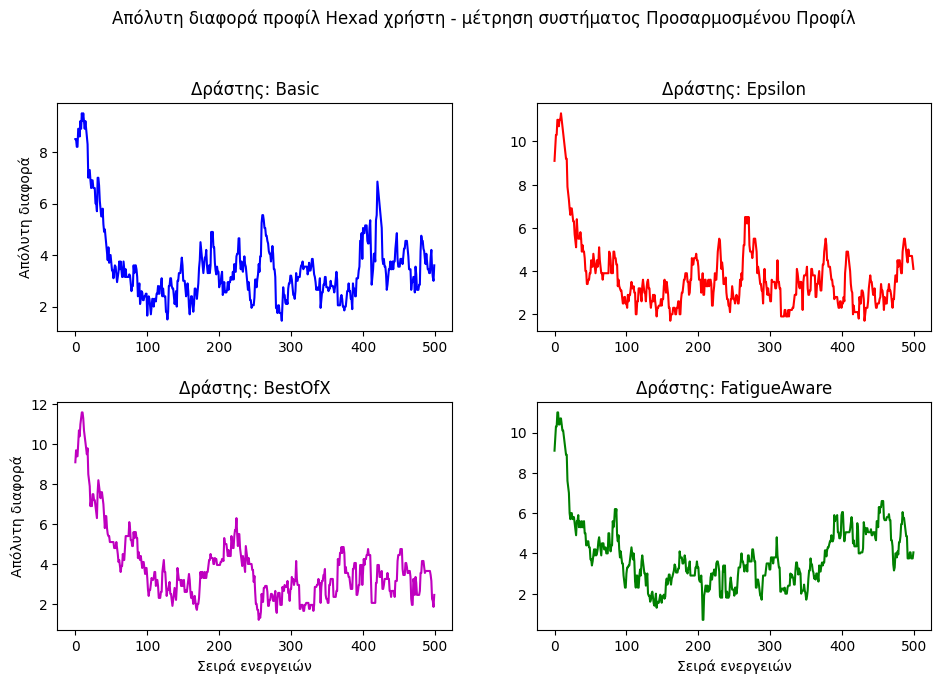

In [213]:
plt.figure()
plt.subplots(2,2)
plt.suptitle("Απόλυτη διαφορά προφίλ Hexad χρήστη - μέτρηση συστήματος Προσαρμοσμένου Προφίλ")
plt.tight_layout(pad=3)
i=1
cs=['b','r','m','g']
for name in profile_diff:
    plt.subplot(2,2,i)
    plt.plot(profile_diff[name],color=cs[i-1])
    plt.title("Δράστης: {}".format(name))
    if i in [3,4]:
        plt.xlabel("Σειρά ενεργειών")   
    if i in [1,3]:
        plt.ylabel("Απόλυτη διαφορά")
    i+=1

Basic
Epsilon
BestOfX
FatigueAware


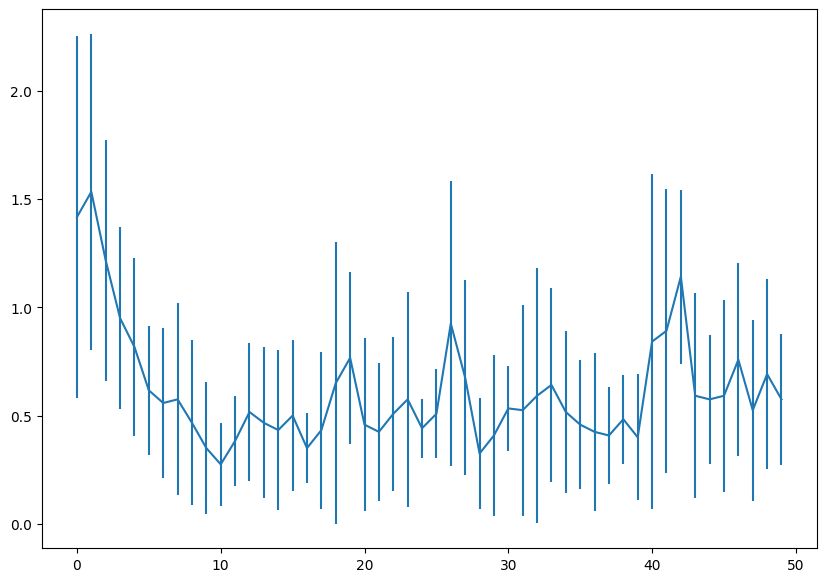

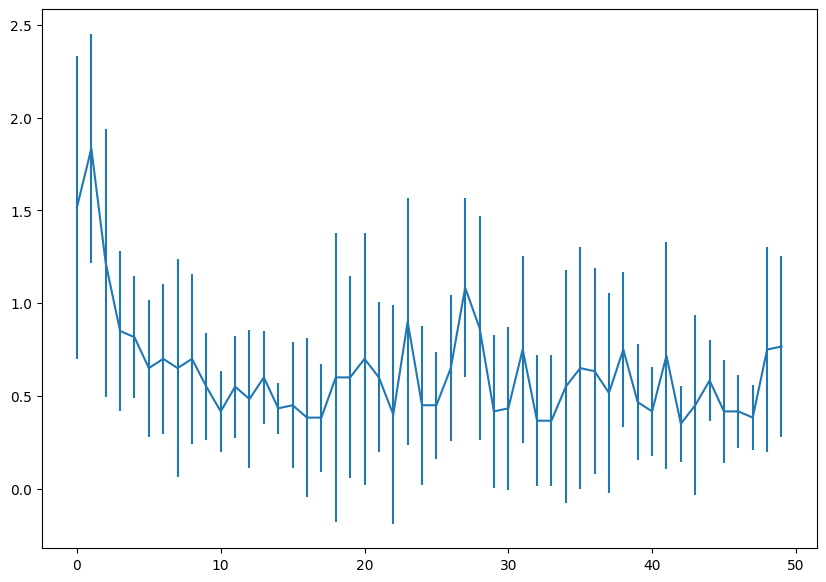

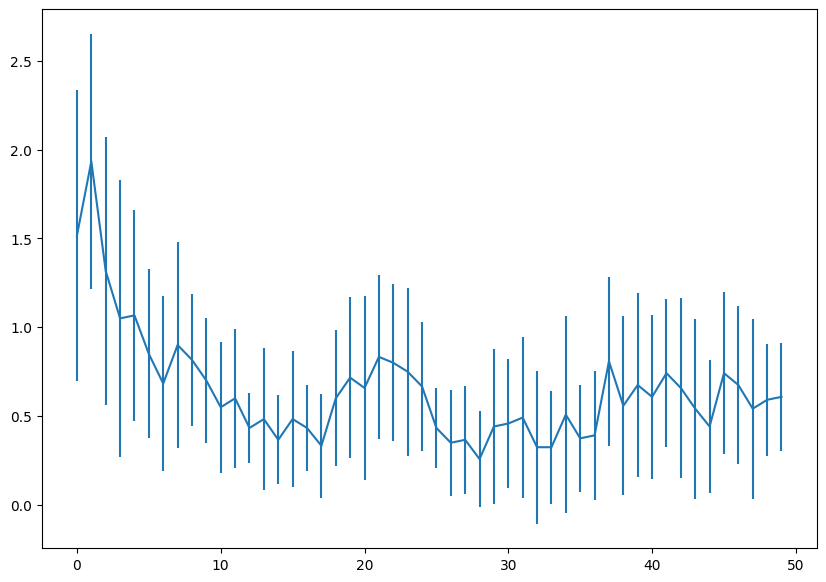

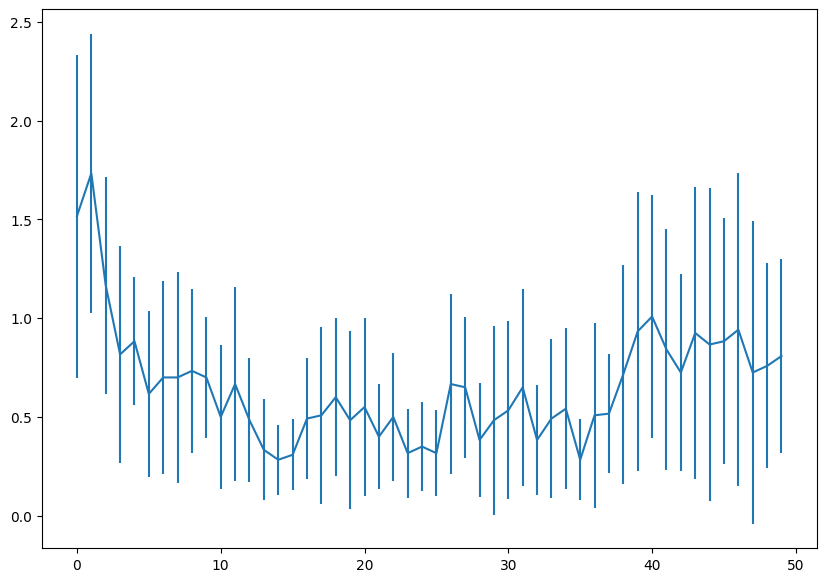

In [214]:
for name in prof_stats:
    print(name)
    plt.figure()
    plt.errorbar(range(len(prof_stats[name]['mean'][::10])),prof_stats[name]["mean"][::10],prof_stats[name]['std'][::10],linestyle=None)